In [1]:
import os
import glob
import sys
import copy as cp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pims as pm
from pims import pipeline
import trackpy as tp
import matplotlib as mpl

sys.path.insert(0, '../icenumerics')
import icenumerics as ice
ureg = ice.ureg
import transformations as tr

sys.path.insert(0, '../Scripts/')
import support as sup
from importlib import reload  
reload(sup)

def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

%load_ext autoreload
%autoreload 2

In [2]:
directory =  "/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/preAnalysis_17-05-2022"

Importing videos in directory

In [3]:
filenames = [file for file in glob.glob(
    os.path.join(directory,('*AVI')))]

filenames = [f for f in filenames]
filenames

['/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/preAnalysis_17-05-2022/Cairo_6x6-0V-4V_600s_h2_w2_exp29_2022_05_19_17_15_09.AVI',
 '/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/preAnalysis_17-05-2022/Cairo_6x6-0V-4V_600s_h2_w2_exp9_2022_05_17_16_10_46_rename.AVI',
 '/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/preAnalysis_17-05-2022/Cairo_6x6-0V-4V_600s_h2_w2_exp20_2022_05_18_16_50_03_rename.AVI',
 '/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/preAnalysis_17-05-2022/Cairo_6x6-0V-4V_600s_h2_w2_exp16_2022_05_18_12_36_36_rename.AVI',
 '/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/preAnalysis_17-05-2022/Cairo_6x6-0V-4V_600s_h2_w2_exp27_2022_05_19_15_39_48.AVI',
 '/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/preAnalysis_17-05-2022/Cairo_6x6-0V-4V_600s_h2_w2_exp26_2022_05_19_15_08_16.AVI',
 '/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/preAnalysis_17-05-2022/Cairo_6x6-0V-4V_6

Reading video

In [4]:
import pandas as pd
idx = pd.IndexSlice
dataset = pd.DataFrame(data = {"scale":3.425,"x_offset":-226,"y_offset":1203,"angle":0}, index=[0])
dataset

,scale,x_offset,y_offset,angle
0,3.425,-226,1203,0


/media/Carol/Magnetic/Experiments/Colloidal_Ice/Cairo_lattice/preAnalysis_17-05-2022/Cairo_6x6-0V-4V_600s_h2_w2_exp31_2022_05_20_11_12_25.AVI


/home/carolina/anaconda3/lib/python3.7/site-packages/pims/api.py:207: UserWarning: <class 'pims.pyav_reader.PyAVReaderTimed'> errored: 'NoneType' object has no attribute 'open'
  warn(message)
/home/carolina/anaconda3/lib/python3.7/site-packages/pims/api.py:207: UserWarning: <class 'pims.pyav_reader.PyAVReaderIndexed'> errored: 'NoneType' object has no attribute 'open'
  warn(message)
Exception ignored in: <function PyAVReaderIndexed.__del__ at 0x7f2cc773f170>
Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/pims/pyav_reader.py", line 368, in __del__
    self._container.close()
AttributeError: 'NoneType' object has no attribute 'close'


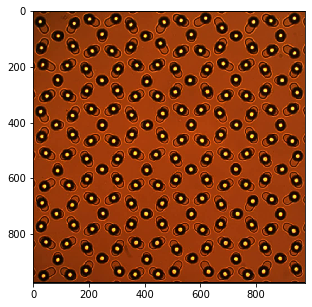

In [5]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

exp = 16
frame = 6000
print(filenames[exp])
fname = filenames[exp]
video = pm.open(fname)
ax.imshow(video[frame])

Setting tracking parameters

In [6]:
diameter = 15
radius = diameter/2
radius

diameter = 2*radius

i = 0    

@pipeline 
def locate(filename):

    return tp.locate(as_gray(filename),  2*round(radius)+1, minmass = 200,topn = 180, threshold = 30)

loc = locate(video[frame])

180

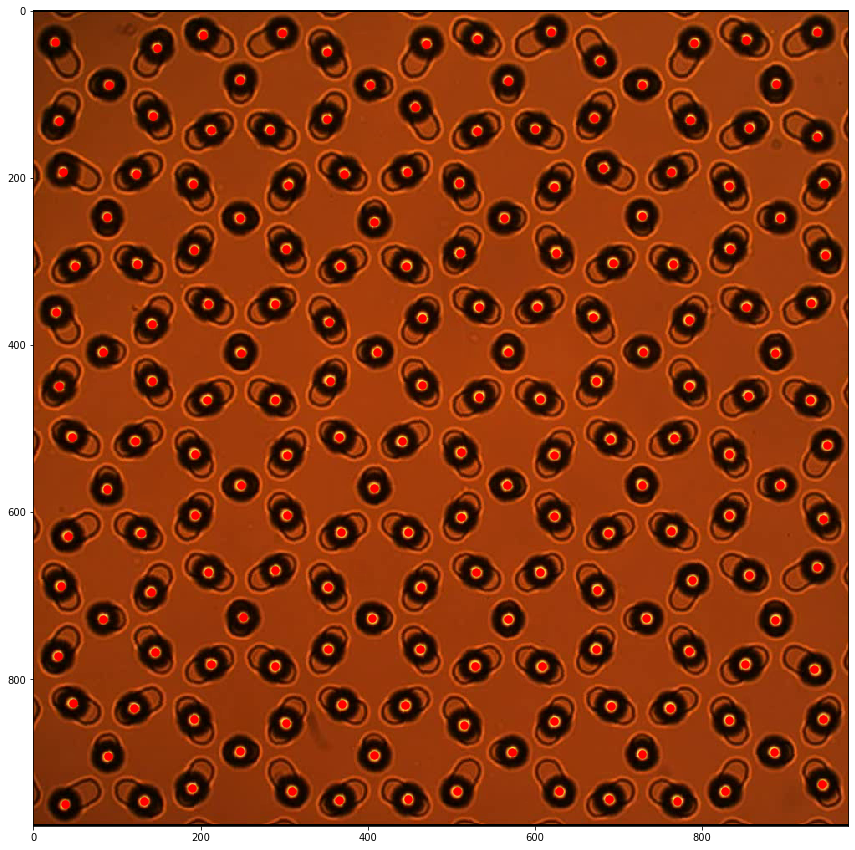

In [7]:
plt.figure(figsize=(15,15))
plt.imshow(video[frame])
plt.plot(loc.x,loc.y,".",markersize=15, color="red")
len(loc.x)

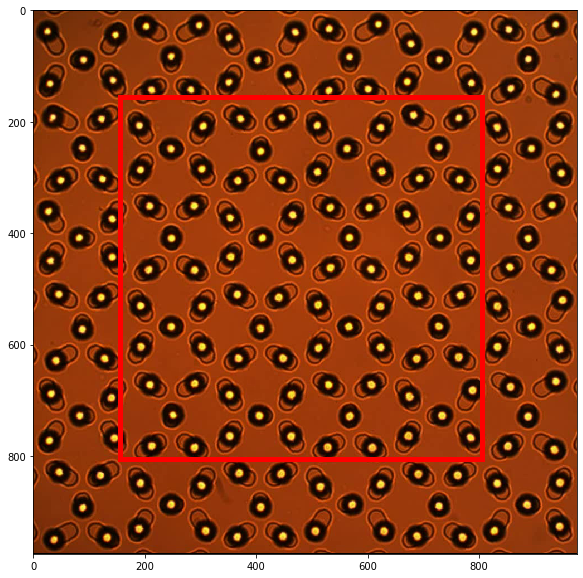

In [8]:
x1 = 155
y1 = 155

height = 650
width = 650

# x1 = 0
# y1 = 0

# height = 960
# width = 960

video_shape = [height,width]
box = mpl.patches.Rectangle(((x1),(y1)),(width),(height),angle = 0, alpha = 1,facecolor='none',edgecolor='r',linewidth=5)

plt.figure(figsize=(10,10))
plt.imshow(video[frame])
currentAxis = plt.gca()
currentAxis.add_patch(box)
plt.savefig('Inner vertices')

In [9]:
def match_colloid_frame(col,trj_frame, x1, y1, width, height):

    video_shape = [height,width]
    box = mpl.patches.Rectangle(((x1),(y1)),(width),(height),angle = 0, alpha = 1,facecolor='none',edgecolor='r',linewidth=2)
    
    remove = []
    
    for i,c in enumerate(col):
        
        if (c.center[0].magnitude > x1) and (c.center[0].magnitude < (x1 + width)) and (c.center[1].magnitude > y1) and (c.center[1].magnitude < (y1 + height)):
            d = np.sqrt((trj_frame.x-c.center[0].magnitude)**2 + (trj_frame.y-c.center[1].magnitude)**2)
            closest = d.idxmin()
            closest_part = trj_frame.loc[idx[closest],:]
            units = c.center.units
            c.colloid = [(closest_part.x-c.center[0].magnitude),(closest_part.y-c.center[1].magnitude),0]*units
            if c.direction@c.colloid<0:
                c.direction = -c.direction 
        else:
            remove.append(i)
            
            
    col.remove(remove)            
    return col

In [10]:
def particle_locations_to_colloids(locations):
    
    entry = dataset.loc[0]
    
    nx = 5
    ny = 5
    a = 19.5458*ureg.um
    
    particle = ice.particle(radius = 13*ureg.um)

    trap_long = ice.trap(trap_sep = 20*ureg.um,
                   height = 30*ureg.pN*ureg.nm,
                   stiffness = 0.1*ureg.fN/ureg.nm)

    trap_short = ice.trap(trap_sep =4.5258*2*ureg.um,
                   height = 30*ureg.pN*ureg.nm,
                  stiffness = 0.1*ureg.fN/ureg.nm)
    
    traps = []

    sp_cairo = sup.spins()
    
    display(entry)
    
    sp_cairo.create_lattice(geometry = "cairo",size =[nx,ny],lattice_constant=a, border="periodic")
    
    for s in sp_cairo:
    
        if ( s.direction[0].magnitude == a.magnitude or s.direction[0].magnitude == -a.magnitude or 
            s.direction[1].magnitude == a.magnitude or s.direction[1].magnitude == -a.magnitude ):
        
            traps.append(trap_short)
        
        else:
        
            traps.append(trap_long)
            
    sp_cairo = tr.rotate(sp_cairo,(entry[["angle"]].values[0])*ureg.deg)
    sp_cairo = tr.scale(sp_cairo,entry[["scale"]].values*np.array([1,1]))
    sp_cairo = tr.translate(sp_cairo,entry[["x_offset","y_offset"]].values*ureg.um)
    
    col = ice.colloidal_ice(sp_cairo, particle, traps, height_spread = 0, susceptibility_spread = 0.1)
    
    col = match_colloid_frame(col,locations, x1, y1, width, height)
    
    return col

In [11]:
%%time
from tqdm import tqdm
tqdm.pandas()

n_frames = 0
for i in range(0,1):
    
    col =  particle_locations_to_colloids(loc)

/home/carolina/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


scale          3.425
x_offset    -226.000
y_offset    1203.000
angle          0.000
Name: 0, dtype: float64

../Scripts/support.py:283: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new_centers[:,1] = centersY
/home/carolina/CairoLattice_ACI_PROJECT/Experiments/transformations.py:39: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  [0,0,1]])


CPU times: user 652 ms, sys: 3.88 ms, total: 656 ms
Wall time: 647 ms


I had to increase the tolerance to remove the double count of vertices in:
    vertices.py file and unique_points() function. I change the tolerance from 0.1 to 0.2.

In [12]:
v = ice.vertices()
v = v.colloids_to_vertices(col)

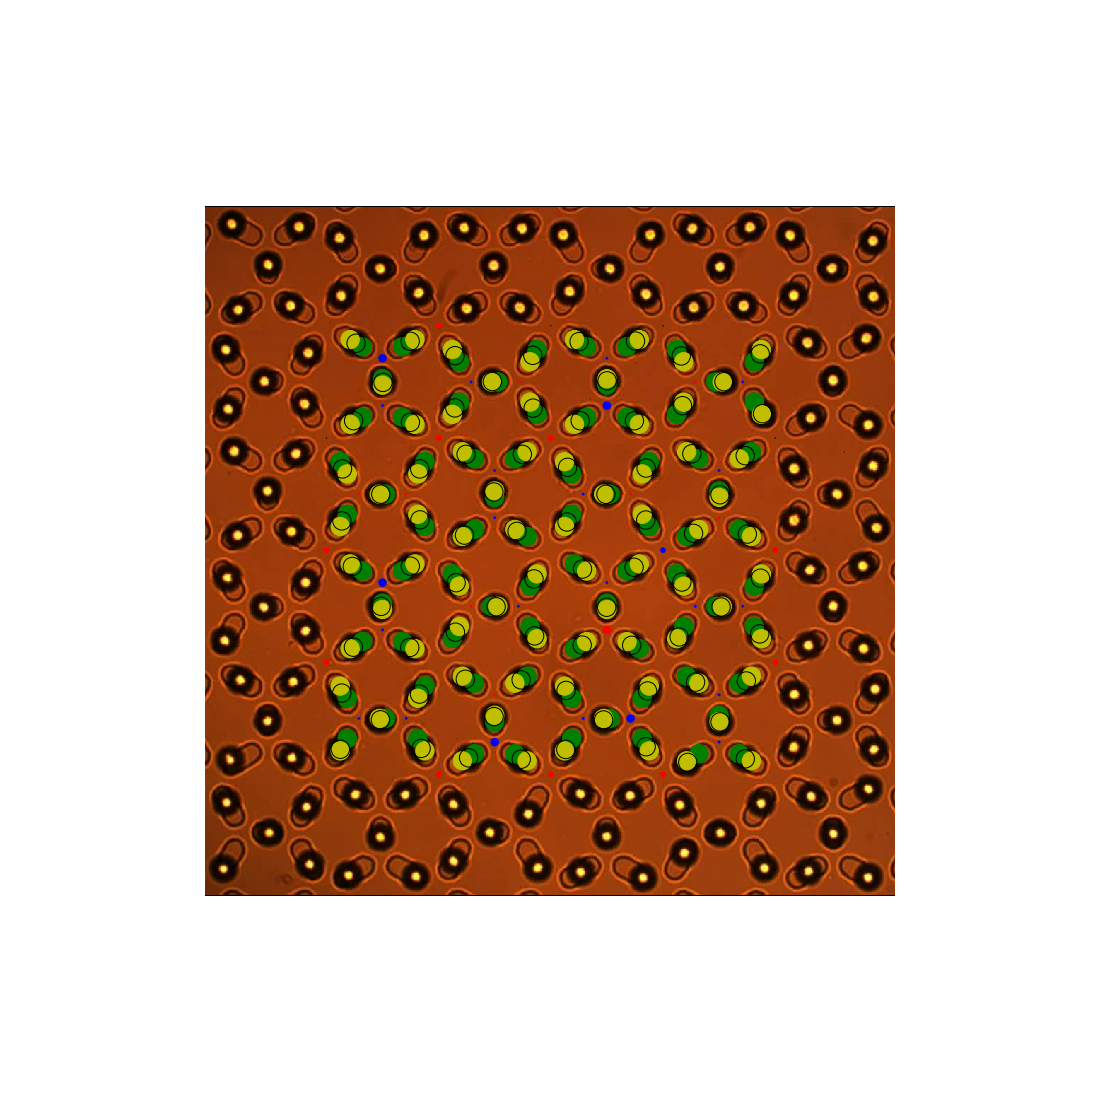

In [13]:
f, (ax1) = plt.subplots(1,1,figsize = (20,20))
# ax1.set_title('$B$ $\sim$ $6$ $mT$',y=-0.009, pad=-14, fontsize=30, size = 60)

ax1.imshow(video[frame], alpha = 1)
v.display(ax1)
plt.axis('off')
col.display(ax1)

#f.savefig(os.path.join(directory,'Analyzed_'+frame_num))

 How I need to filter the c.colloid data to have meaninful histograms?

(array([0.03985496, 0.06642494, 0.03985496, 0.05313995, 0.07970993,
        0.06642494, 0.17270484, 0.13284988, 0.15941985, 0.03985496]),
 array([-7.77021692, -6.59407733, -5.41793774, -4.24179815, -3.06565856,
        -1.88951897, -0.71337939,  0.4627602 ,  1.63889979,  2.81503938,
         3.99117897]),
 <a list of 10 Patch objects>)

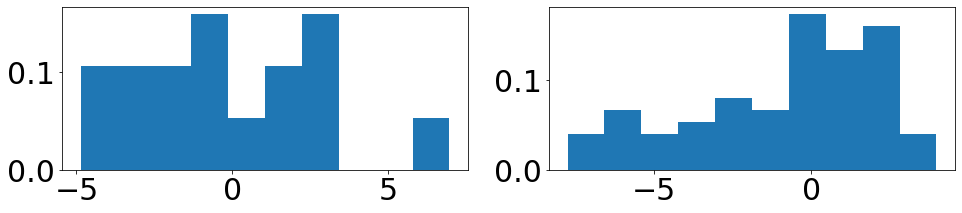

In [14]:
variable_v = []
variable_h = []

fixed_r = []
fixed_l = []

for c in col:
    if (c.direction[0] == 1 or c.direction[0] == -1):
        variable_h.append(c.colloid.magnitude)
        
    elif (c.direction[1] == 1 or c.direction[1] == -1):
        variable_v.append(c.colloid.magnitude)
        
    elif (c.direction[1] > 0.5 or c.direction[1] < -0.5):
        fixed_r.append(c.colloid.magnitude)
    else:
        fixed_l.append(c.colloid.magnitude)
        
var_v = np.array(variable_v)
var_h = np.array(variable_h)
fixed_r = np.array(fixed_r)
fixed_l = np.array(fixed_l)

variable = np.concatenate((var_v[:,1],var_h[:,0]))
fixed = np.concatenate((fixed_r[:,1],fixed_l[:,0]))
    
    
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16,3))

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30) 
ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30) 
#ax1.set_title('variable trap, '+str(round(a-2*s_l3))+' $ \mu m$' , size = 32)
#ax2.set_title(r'fixed trap, 10 $ \mu m$ length' , size = 32)
ax1.hist(variable, density = True, stacked = True)
ax2.hist(fixed, density = True, stacked = True)